# EDA for Reddit- Wallstreebeets comments 2018-2021

references https://www.earthdatascience.org/courses/use-data-open-source-python/intro-to-apis/calculate-tweet-word-frequencies-in-python/

In [1]:
import pandas as pd
import numpy as np
import datetime
import matplotlib.pyplot as plt
import json
import vaex
import re
import itertools
import collections
import nltk
from nltk.corpus import stopwords
#from textblob import TextBlob
from nltk.sentiment.vader import SentimentIntensityAnalyzer

from wordcloud import WordCloud
import yfinance as yf

### input data processing

The data was downloaded from the internet from  http://files.pushshift.io/reddit/comments/

The files are compressed in Zstandard format. A script was used to convert ehe files from Zst to JSON or CSV depending in the particular file. This was done outside of this jupyter notebook

In [2]:
#2018_2019_clean_vader

# Import data from CSV with 
df_2018_2019 = vaex.from_csv('2018_2019_clean_vader.csv', convert=True, chunk_size=5_000_000, low_memory=False)


In [3]:
df_2018_2019.info()

column,type,unit,description,expression
Unnamed: 0,int64,,,
author,str,,,
created_utc,str,,,
body,str,,,
score,float64,,,
body_no_urls,str,,,
words_in_body,str,,,
vader_score,str,,,
vader_compound,float64,,,
vader_category,str,,,


In [4]:
df_2020 = vaex.from_csv('2020_clean_vader.csv', convert=True, chunk_size=5_000_000, low_memory=False)

In [5]:
df_2020.info()

column,type,unit,description,expression
Unnamed: 0,int64,,,
author,str,,,
created_utc,str,,,
body,str,,,
score,int64,,,
body_no_urls,str,,,
words_in_body,str,,,
vader_score,str,,,
vader_compound,float64,,,
vader_category,str,,,


In [6]:
df_2021 = vaex.from_csv('2021_clean_vader.csv', convert=True, chunk_size=5_000_000, low_memory=False)

In [7]:
df_2021.info()

column,type,unit,description,expression
Unnamed: 0,int64,,,
author,str,,,
created_utc,str,,,
body,str,,,
score,int64,,,
body_no_urls,str,,,
words_in_body,str,,,
vader_score,str,,,
vader_compound,float64,,,
vader_category,str,,,


In [8]:
# concatenate all three years
new_df = vaex.concat([df_2018_2019, df_2020, df_2021])

In [9]:
new_df.info()

column,type,unit,description,expression
Unnamed: 0,int64,,,
author,str,,,
created_utc,str,,,
body,str,,,
score,float64,,,
body_no_urls,str,,,
words_in_body,str,,,
vader_score,str,,,
vader_compound,float64,,,
vader_category,str,,,


In [10]:
# convert to pandas -- this requires memory since all objects are in RAM
pandas_df = new_df.to_pandas_df()

In [14]:
# convert ojbect to datetime 
pandas_df['created_utc'] = pd.to_datetime(pandas_df['created_utc'])

In [15]:
pandas_df

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,vader_score,vader_compound,vader_category,company
0,1,08371A,2018-01-01 00:00:54,Bless you,6.0,Bless you,bless,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp...",0.4215,positive,None
1,2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0,Long winded clickbait ad,long winded clickbait ad,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,None
2,3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...,part point spy sector affected investors secto...,"{'neg': 0.044, 'neu': 0.956, 'pos': 0.0, 'comp...",-0.1531,negative,None
3,4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0,Undergrad grad school the CFA exam and Google,undergrad grad school cfa exam google,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,None
4,6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS,aapl mtch amd dis,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,AMD AAPL DIS MTCH
...,...,...,...,...,...,...,...,...,...,...,...
38458747,24263906,'fin425',2021-06-30 23:59:38,'I was doing this. Only smoke when I drink and...,3.0,I was doing this Only smoke when I drink and o...,smoke drink drugs quitting daily use roll juul...,"{'neg': 0.058, 'neu': 0.857, 'pos': 0.085, 'co...",0.2960,positive,None
38458748,24263909,'middleclasswarfare',2021-06-30 23:59:50,'Bitches sell...legends hold',31.0,Bitches sell legends hold,bitches sell legends hold,"{'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'comp...",-0.5994,negative,None
38458749,24263911,'Funguyguy',2021-06-30 23:59:53,"'Time will tell, little 5K YOLO 🤞\n\n$42 in 7-...",1.0,Time will tell little 5K YOLO n n 42 in 7 10 d...,time tell little 5k yolo n n 42 7 10 days bust,"{'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'comp...",0.3725,positive,None
38458750,24263912,'StonedTurtle420710',2021-06-30 23:59:53,'How is this getting down voted? What the hell?',1.0,How is this getting down voted What the hell,getting voted hell,"{'neg': 0.365, 'neu': 0.635, 'pos': 0.0, 'comp...",-0.6808,negative,None


In [16]:
pandas_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38458752 entries, 0 to 38458751
Data columns (total 11 columns):
 #   Column          Dtype         
---  ------          -----         
 0   Unnamed: 0      int64         
 1   author          object        
 2   created_utc     datetime64[ns]
 3   body            object        
 4   score           float64       
 5   body_no_urls    object        
 6   words_in_body   object        
 7   vader_score     object        
 8   vader_compound  float64       
 9   vader_category  object        
 10  company         object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(7)
memory usage: 3.2+ GB


# volume of comments

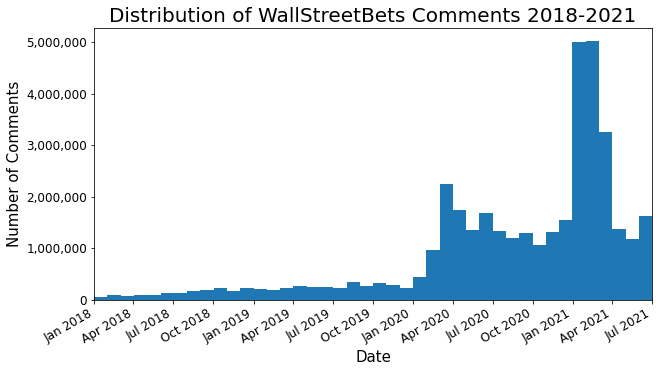

In [17]:
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

fig, axs = plt.subplots(1,1, figsize=(10,5))
axs.hist(pandas_df['created_utc'],  bins=42, cumulative = False   )

axs.set( xlim = [datetime.datetime(2018, 1, 1),datetime.datetime(2021, 7, 1)],
       xlabel='Date', 
       ylabel='Number of Comments',
       title='Distribution of WallStreetBets Comments 2018-2021')

axs.get_yaxis().set_major_formatter(
mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

axs.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
axs.xaxis.set_major_formatter(mdates.DateFormatter("%b %Y"))
plt.setp(axs.get_xticklabels(), rotation=30, ha="right")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(20)

pass

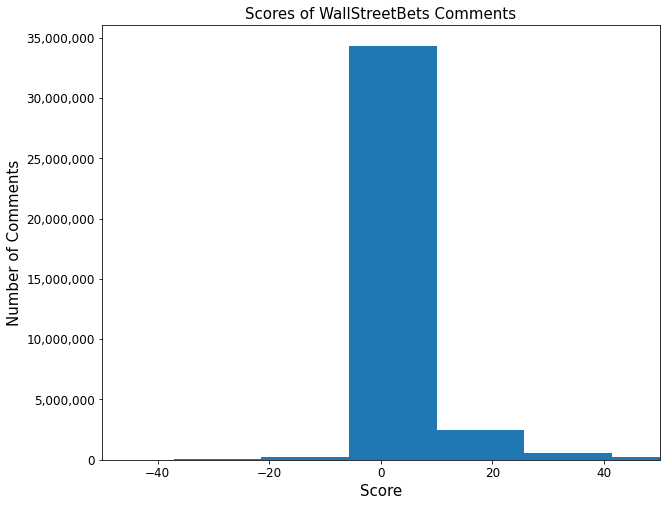

In [18]:
import matplotlib.ticker as mtick
import matplotlib.dates as mdates

fig, axs = plt.subplots(1,1, figsize=(10,8))
axs.hist(pandas_df['score'],  bins=3000, cumulative = False   )

axs.set( xlim = [-50,50], xlabel='Score', 
       ylabel='Number of Comments',
       title='Scores of WallStreetBets Comments')

axs.get_yaxis().set_major_formatter(
mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

#plt.setp(axs.get_xticklabels(), rotation=30, ha="right")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

pass

In [19]:
# remove teh stopwoirds
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/javier/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [20]:
stop_words = set(stopwords.words('english'))

# View a few words from the set
list(stop_words)[0:10]

["won't", 'here', 'nor', 'own', 'shan', 'yours', 'up', 'i', 'ain', 'had']

In [19]:
# remove the stopwords from teh dictionary with counts
from collections import Counter

stop_words = stopwords.words('english') + ["well", "bro", "low", "see", "tech", "amp", "ni"]

stopwords_dict = Counter(stop_words)

def remove_stopwords(txt, stopwords=stopwords_dict ):
    """Replace stopwords found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with stopwrods removed.
    """

    return ' '.join([word for word in txt.split() if word not in stopwords_dict])

In [20]:
#THis will count the number of mentions of words, 
clean_body_no_urls =pandas_df.words_in_body.str.split().explode().value_counts().to_frame()
clean_body_no_urls.reset_index(inplace = True)
clean_body_no_urls.rename(columns = {'index':'word', 'words_in_body':'count'}, inplace = True)
clean_body_no_urls.head(10)

,word,count
0,n,5928774
1,like,2560774
2,buy,1968617
3,get,1792801
4,calls,1559809
5,go,1448630
6,money,1435323
7,going,1404012
8,gme,1264635
9,market,1233699


In [21]:
# get the SP500 tickers
table=pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
SP_500 = table[0]['Symbol'].tolist()

In [22]:
SP_500_dict =  dict(zip(clean_body_no_urls['word'], clean_body_no_urls['count']))

In [23]:
count_ticker = []

for company in SP_500:
    count_ticker.append(SP_500_dict.get(company.lower()))


df_ticker_count = pd.DataFrame(
    {'company': SP_500,
     'count': count_ticker
    })

In [24]:
df_ticker_count.head(10)

,company,count
0,MMM,5579.0
1,AOS,42.0
2,ABT,4374.0
3,ABBV,1483.0
4,ABMD,97.0
5,ACN,109.0
6,ATVI,23721.0
7,ADM,231.0
8,ADBE,2745.0
9,ADP,815.0


In [39]:
#remove NI and AMP since theyre not valid mentions
df_ticker_count.drop(df_ticker_count[df_ticker_count['company']=="NI"].index,inplace = True)
df_ticker_count.drop(df_ticker_count[df_ticker_count['company']=="AMP"].index,inplace = True)

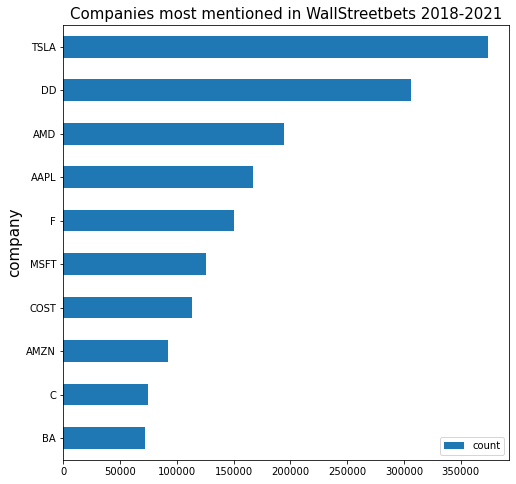

In [60]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df_ticker_count.sort_values(by='count', ascending=False).head(10).plot.barh(x='company',
                      y='count',
                      ax=ax,
                      )
ax.invert_yaxis()
ax.title.set_size(25)
ax.set_title("Companies most mentioned in WallStreetbets 2018-2021")
ax.title.set_size(15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.show()

In [27]:
lengths = pandas_df["body_no_urls"].str.len()
argmax = np.where(lengths == lengths.max())[0]
lenghts= lengths.to_frame(name = 'count')

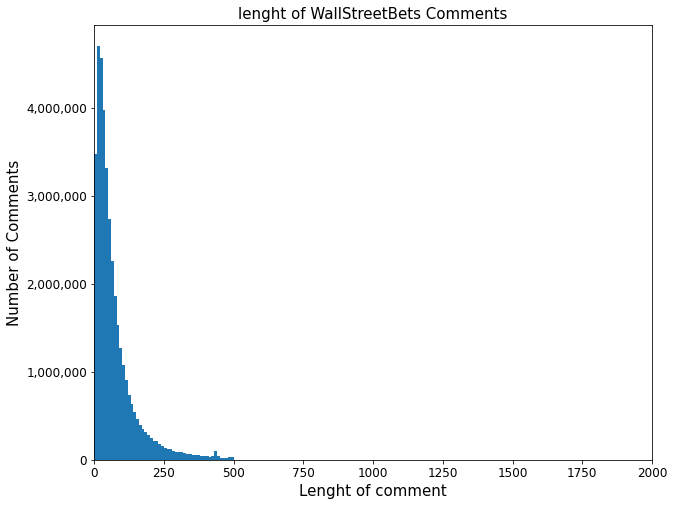

In [43]:
fig, axs = plt.subplots(1,1, figsize=(10,8))
axs.hist(lenghts['count'],  bins=50, cumulative = False   )

axs.set( xlim = [0,2000], xlabel='Lenght of comment', 
       ylabel='Number of Comments',
       title='lenght of WallStreetBets Comments')

axs.get_yaxis().set_major_formatter(
mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

#plt.setp(axs.get_xticklabels(), rotation=30, ha="right")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

In [44]:
# based on the above histogram, we dropped very long comments about 500 words.
#lengths = df_2018_2019["body_no_urls"].str.len()

pandas_df.drop(pandas_df[pandas_df['body_no_urls'].str.len() > 500].index, inplace = True)

In [45]:
pandas_df

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,vader_score,vader_compound,vader_category,company
0,1,08371A,2018-01-01 00:00:54,Bless you,6.0,Bless you,bless,"{'neg': 0.0, 'neu': 0.263, 'pos': 0.737, 'comp...",0.4215,positive,None
1,2,Dick_Cuckingham,2018-01-01 00:02:28,Long winded clickbait ad.,26.0,Long winded clickbait ad,long winded clickbait ad,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,None
2,3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...,part point spy sector affected investors secto...,"{'neg': 0.044, 'neu': 0.956, 'pos': 0.0, 'comp...",-0.1531,negative,None
3,4,Shauncore,2018-01-01 00:03:25,"Undergrad, grad school, the CFA exam, and Google.",6.0,Undergrad grad school the CFA exam and Google,undergrad grad school cfa exam google,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,None
4,6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS,aapl mtch amd dis,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,AMD AAPL DIS MTCH
...,...,...,...,...,...,...,...,...,...,...,...
38458747,24263906,'fin425',2021-06-30 23:59:38,'I was doing this. Only smoke when I drink and...,3.0,I was doing this Only smoke when I drink and o...,smoke drink drugs quitting daily use roll juul...,"{'neg': 0.058, 'neu': 0.857, 'pos': 0.085, 'co...",0.2960,positive,None
38458748,24263909,'middleclasswarfare',2021-06-30 23:59:50,'Bitches sell...legends hold',31.0,Bitches sell legends hold,bitches sell legends hold,"{'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'comp...",-0.5994,negative,None
38458749,24263911,'Funguyguy',2021-06-30 23:59:53,"'Time will tell, little 5K YOLO 🤞\n\n$42 in 7-...",1.0,Time will tell little 5K YOLO n n 42 in 7 10 d...,time tell little 5k yolo n n 42 7 10 days bust,"{'neg': 0.0, 'neu': 0.846, 'pos': 0.154, 'comp...",0.3725,positive,None
38458750,24263912,'StonedTurtle420710',2021-06-30 23:59:53,'How is this getting down voted? What the hell?',1.0,How is this getting down voted What the hell,getting voted hell,"{'neg': 0.365, 'neu': 0.635, 'pos': 0.0, 'comp...",-0.6808,negative,None


## Sentiment Vader

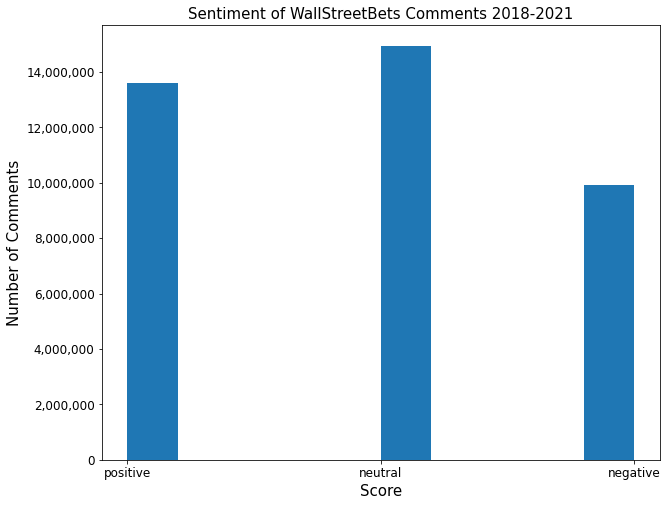

In [47]:
# make  chart of comments
fig, axs = plt.subplots(1,1, figsize=(10,8))
axs.hist(pandas_df['vader_category'],  cumulative = False   )

axs.set( xlabel='Score', 
       ylabel='Number of Comments',
       title='Sentiment of WallStreetBets Comments 2018-2021')

axs.get_yaxis().set_major_formatter(
mtick.FuncFormatter(lambda x, p: format(int(x), ',')))

#plt.setp(axs.get_xticklabels(), rotation=30, ha="right")
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

pass

In [48]:
# following Ranco proposed formula for sentiment polarity Pd
#Get the average of polarity daily  of posts

daily_vader_polarity_posts = pandas_df.groupby(pd.Grouper(key='created_utc',freq='M'))['vader_category'].value_counts().unstack(fill_value=0)

daily_vader_polarity_posts


vader_category,negative,neutral,positive
created_utc,,,
2018-01-31,17673,24075,23867
2018-02-28,24103,30552,29294
2018-03-31,25505,30490,30820
2018-04-30,26268,30714,32356
2018-05-31,27792,35362,37751
2018-06-30,35360,46794,47664
2018-07-31,35970,45670,50613
2018-08-31,46011,61507,65690
2018-09-30,51387,71086,72710


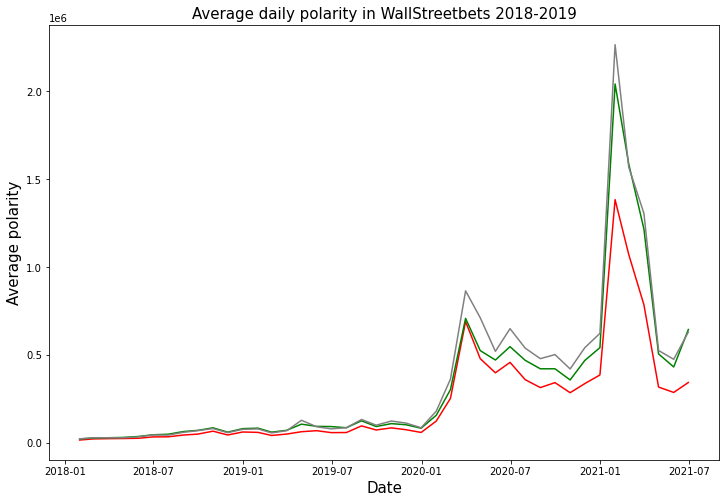

In [49]:
fig, axs = plt.subplots(1,1, figsize=(12,8))

axs.plot( daily_vader_polarity_posts['negative'], label = "polarity", color = 'red')
axs.plot( daily_vader_polarity_posts['positive'], label = "polarity", color = 'green')
axs.plot( daily_vader_polarity_posts['neutral'], label = "polarity", color = 'gray')
axs.set( 
       xlabel='Date', 
       ylabel='Average polarity',
       title='Average daily polarity in WallStreetbets 2018-2019')
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)

axs.title.set_size(15)

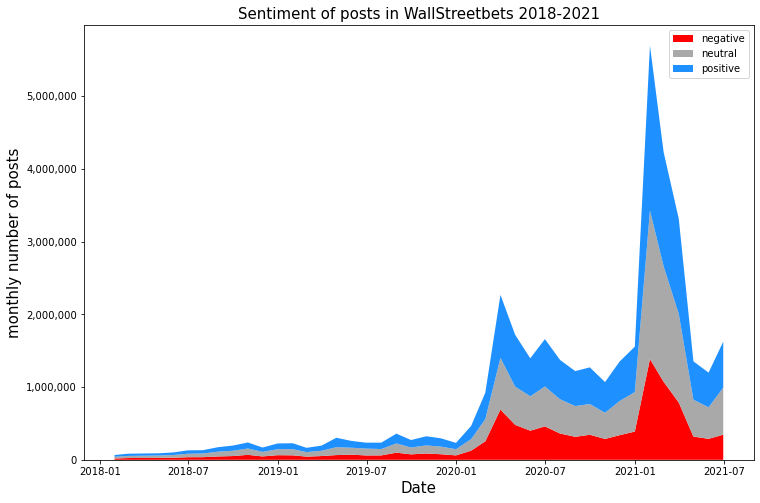

In [50]:
fig, axs = plt.subplots(1,1, figsize=(12,8))
pal = ["red", "darkgray", "dodgerblue"]
axs.stackplot(daily_vader_polarity_posts.index, daily_vader_polarity_posts['negative'], daily_vader_polarity_posts['positive'],daily_vader_polarity_posts['neutral'], labels=daily_vader_polarity_posts.columns, colors = pal  )

axs.set( 
       xlabel='Date', 
       ylabel='monthly number of posts',
       title='Sentiment of posts in WallStreetbets 2018-2021')
axs.legend()
axs.get_yaxis().set_major_formatter(
mtick.FuncFormatter(lambda x, p: format(int(x), ',')))
axs.xaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.yaxis.label.set_size(15)
axs.title.set_size(15)

In [51]:
SP_500_dict.get('AMC')

In [52]:
# i want to categorize the feeling about a company
#Filter where comments are negative
pandas_df_negative = pandas_df[pandas_df["vader_category"]=="negative"]
pandas_df_positive = pandas_df[pandas_df["vader_category"]=="positive"]
pandas_df_neutral = pandas_df[pandas_df["vader_category"]=="neutral"]

In [53]:
# calculate counts of words here

negative_comments =pandas_df_negative.words_in_body.str.split().explode().value_counts().to_frame()
negative_comments.reset_index(inplace = True)
negative_comments.rename(columns = {'index':'word', 'words_in_body':'count'}, inplace = True)

positive_comments =pandas_df_positive.words_in_body.str.split().explode().value_counts().to_frame()
positive_comments.reset_index(inplace = True)
positive_comments.rename(columns = {'index':'word', 'words_in_body':'count'}, inplace = True)

neutral_comments =pandas_df_neutral.words_in_body.str.split().explode().value_counts().to_frame()
neutral_comments.reset_index(inplace = True)
neutral_comments.rename(columns = {'index':'word', 'words_in_body':'count'}, inplace = True)

In [54]:
negative_SP_500_dict =  dict(zip(negative_comments['word'], negative_comments['count']))
positive_SP_500_dict =  dict(zip(positive_comments['word'], positive_comments['count']))
neutral_SP_500_dict =  dict(zip(neutral_comments['word'], neutral_comments['count']))

In [61]:
count_ticker_negative = []
count_ticker_positive = []
count_ticker_neutral = []

for company in SP_500:
    count_ticker_negative.append(negative_SP_500_dict.get(company.lower()))
    count_ticker_positive.append(positive_SP_500_dict.get(company.lower()))
    count_ticker_neutral.append(neutral_SP_500_dict.get(company.lower()))


df_ticker_count_negative = pd.DataFrame(
    {'company': SP_500,
     'count': count_ticker_negative
    })
df_ticker_count_positive = pd.DataFrame(
    {'company': SP_500,
     'count': count_ticker_positive
    })
df_ticker_count_neutral = pd.DataFrame(
    {'company': SP_500,
     'count': count_ticker_neutral
    })

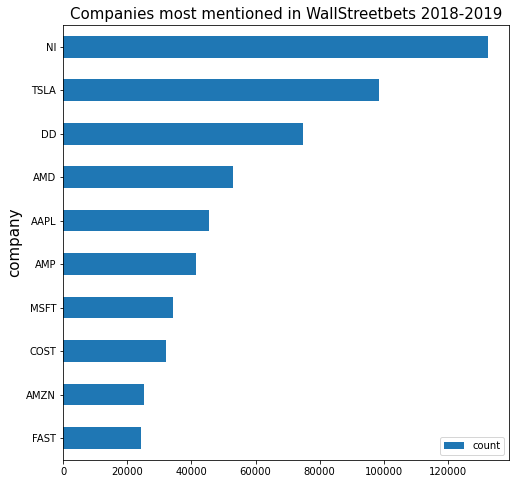

In [64]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df_ticker_count_negative.sort_values(by='count', ascending=False).head(10).plot.barh(x='company',
                      y='count',
                      ax=ax,
                      )
ax.invert_yaxis()
ax.title.set_size(25)
ax.set_title("Companies most mentioned in WallStreetbets 2018-2019")
ax.title.set_size(15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.show()

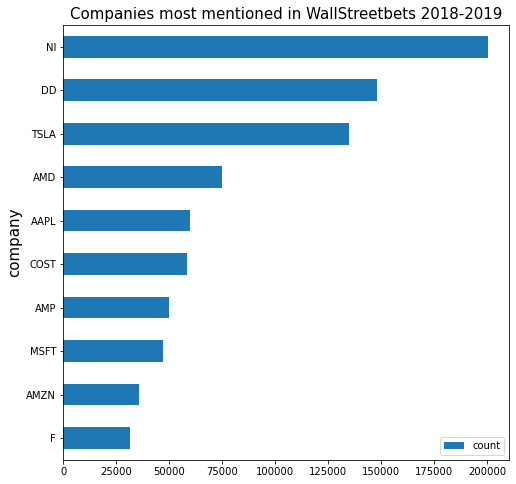

In [65]:
fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
df_ticker_count_positive.sort_values(by='count', ascending=False).head(10).plot.barh(x='company',
                      y='count',
                      ax=ax,
                      )
ax.invert_yaxis()
ax.title.set_size(25)
ax.set_title("Companies most mentioned in WallStreetbets 2018-2019")
ax.title.set_size(15)
ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)
plt.show()

In [89]:
# make word cloud of positive and negative companies
#pandas_df_negative
pandas_df_negative

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,vader_score,vader_compound,vader_category,company
2,3,Shauncore,2018-01-01 00:02:42,And that's part of the point. SPY isn't just a...,11.0,And that s part of the point SPY isn t just a ...,part point spy sector affected investors secto...,"{'neg': 0.044, 'neu': 0.956, 'pos': 0.0, 'comp...",-0.1531,negative,None
10,12,TheHornyHobbit,2018-01-01 00:08:14,I think we’re more insane than autistic. Why e...,41.0,I think we re more insane than autistic Why el...,think insane autistic else would keep investin...,"{'neg': 0.164, 'neu': 0.836, 'pos': 0.0, 'comp...",-0.6855,negative,None
12,14,sk8er4514,2018-01-01 00:14:50,Cramer wrote a similar article on The Street. ...,6.0,Cramer wrote a similar article on The Street I...,cramer wrote similar article street click bait...,"{'neg': 0.134, 'neu': 0.866, 'pos': 0.0, 'comp...",-0.5719,negative,None
17,20,pdjksfuwohfbnwjk9975,2018-01-01 00:20:23,"Leo Sun - remember the name of the enemy ,MU T...",2.0,Leo Sun remember the name of the enemy MU TO T...,leo sun remember name enemy mu moooooooooooooo...,"{'neg': 0.241, 'neu': 0.759, 'pos': 0.0, 'comp...",-0.5423,negative,MU
18,21,brutalpancake,2018-01-01 00:20:48,I’m not thinking of selling...that doesn’t mea...,1.0,I m not thinking of selling that doesn t mean ...,thinking selling mean lose buttload money tho ...,"{'neg': 0.116, 'neu': 0.788, 'pos': 0.096, 'co...",-0.2846,negative,None
...,...,...,...,...,...,...,...,...,...,...,...
38458726,24263881,'Kindly-Somewhere-14',2021-06-30 23:58:34,'Dump',1.0,Dump,dump,"{'neg': 1.0, 'neu': 0.0, 'pos': 0.0, 'compound...",-0.3818,negative,None
38458733,24263889,'-bjorn',2021-06-30 23:58:50,'I was mad I missed it sub 10 for that short c...,3.0,I was mad I missed it sub 10 for that short co...,mad missed sub 10 short couple minutes,"{'neg': 0.31, 'neu': 0.69, 'pos': 0.0, 'compou...",-0.6597,negative,None
38458736,24263893,'DRXKX',2021-06-30 23:59:09,'Oh no not GOEV again...',1.0,Oh no not GOEV again,oh goev,"{'neg': 0.355, 'neu': 0.645, 'pos': 0.0, 'comp...",-0.2960,negative,None
38458748,24263909,'middleclasswarfare',2021-06-30 23:59:50,'Bitches sell...legends hold',31.0,Bitches sell legends hold,bitches sell legends hold,"{'neg': 0.565, 'neu': 0.435, 'pos': 0.0, 'comp...",-0.5994,negative,None


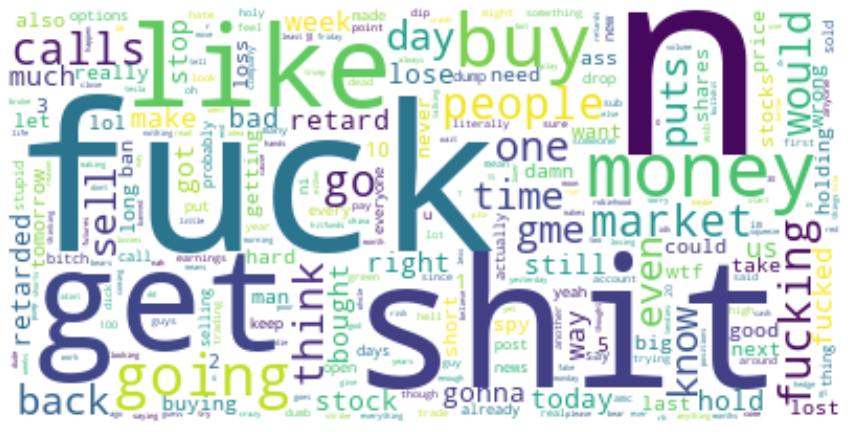

In [92]:
wordcloud = WordCloud(stopwords=stop_words, background_color="white", max_words = 1000)
wordcloud.generate_from_frequencies(negative_SP_500_dict)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


In [109]:
#companies in negative!
# drop nan
df_ticker_count_negative = df_ticker_count_negative.dropna()

#remove NI and AMP since theyre not valid mentions
df_ticker_count_negative.drop(df_ticker_count_negative[df_ticker_count_negative['company']=="NI"].index,inplace = True)
df_ticker_count_negative.drop(df_ticker_count_negative[df_ticker_count_negative['company']=="AMP"].index,inplace = True)

zip_dictionary = df_ticker_count_negative.set_index('company')['count'].to_dict()
zip_dictionary

{'MMM': 1037.0,
 'AOS': 12.0,
 'ABT': 1290.0,
 'ABBV': 321.0,
 'ABMD': 20.0,
 'ACN': 18.0,
 'ATVI': 7050.0,
 'ADM': 47.0,
 'ADBE': 677.0,
 'ADP': 286.0,
 'AAP': 57.0,
 'AES': 60.0,
 'AFL': 29.0,
 'APD': 15.0,
 'AKAM': 27.0,
 'ALK': 161.0,
 'ALB': 78.0,
 'ALGN': 180.0,
 'ALLE': 91.0,
 'LNT': 1.0,
 'GOOGL': 1492.0,
 'GOOG': 2362.0,
 'MO': 3379.0,
 'AMZN': 25078.0,
 'AMCR': 6.0,
 'AMD': 52925.0,
 'AEE': 16.0,
 'AAL': 7408.0,
 'AEP': 19.0,
 'AXP': 378.0,
 'AIG': 289.0,
 'AMT': 182.0,
 'AWK': 38.0,
 'ABC': 488.0,
 'AME': 78.0,
 'AMGN': 36.0,
 'APH': 108.0,
 'ADI': 29.0,
 'ANSS': 4.0,
 'AON': 19.0,
 'APA': 90.0,
 'AAPL': 45371.0,
 'AMAT': 1087.0,
 'APTV': 7.0,
 'ANET': 47.0,
 'AJG': 1.0,
 'AIZ': 3.0,
 'ATO': 6.0,
 'ADSK': 106.0,
 'AZO': 48.0,
 'AVB': 11.0,
 'AVY': 6.0,
 'BKR': 29.0,
 'BALL': 7927.0,
 'BAC': 4248.0,
 'BAX': 1.0,
 'BDX': 16.0,
 'WRB': 6.0,
 'BBY': 2551.0,
 'BIO': 1473.0,
 'BIIB': 344.0,
 'BLK': 93.0,
 'BK': 1059.0,
 'BA': 20896.0,
 'BKNG': 156.0,
 'BWA': 14.0,
 'BXP': 12.0,
 '

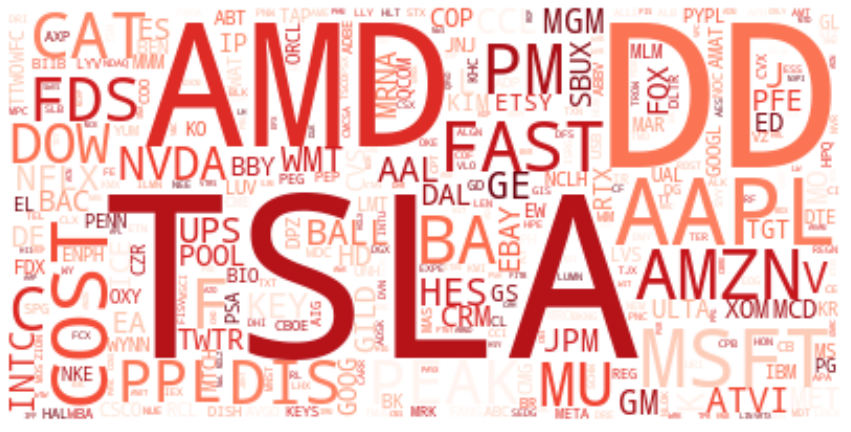

In [114]:
wordcloud = WordCloud(stopwords=stop_words, colormap ="Reds", max_words = 1000, background_color="white")
wordcloud.generate_from_frequencies(zip_dictionary)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()


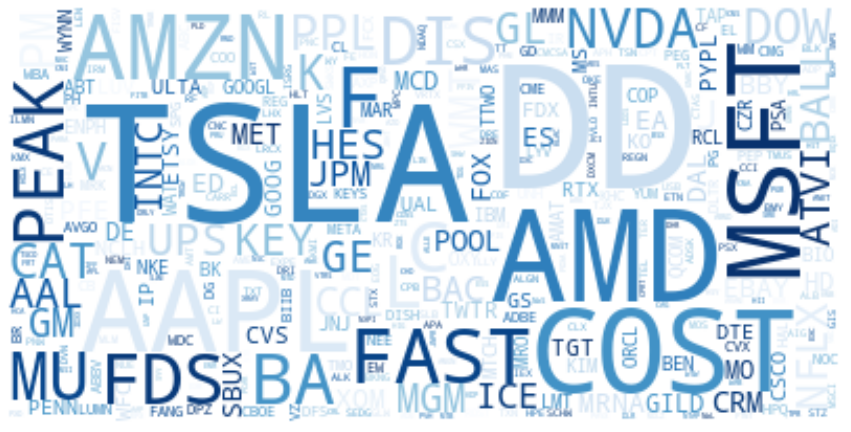

In [115]:
#companies in positive!
# drop nan
df_ticker_count_positive = df_ticker_count_positive.dropna()

#remove NI and AMP since theyre not valid mentions
df_ticker_count_positive.drop(df_ticker_count_positive[df_ticker_count_positive['company']=="NI"].index,inplace = True)
df_ticker_count_positive.drop(df_ticker_count_positive[df_ticker_count_positive['company']=="AMP"].index,inplace = True)

zip_dictionary = df_ticker_count_positive.set_index('company')['count'].to_dict()

wordcloud = WordCloud(stopwords=stop_words, colormap ="Blues", max_words = 1000, background_color="white")
wordcloud.generate_from_frequencies(zip_dictionary)
plt.figure( figsize=(15,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [220]:
# sentiment abotu AMD as example
# make data frame with companies mentioned in teh body
import re
def find_tickers(txt, list_companies):
    
    result = ""
    for company in list_companies:
        
        if is_word_in_text(company, txt) :
            result = result + " " + (company)
            

    return result



def is_word_in_text(word, text):
    """
    Check if a word is in a text.

    Parameters
    ----------
    word : str
    text : str

    Returns
    -------
    bool : True if word is in text, otherwise False.

    Examples
    --------
    >>> is_word_in_text("Python", "python is awesome.")
    True

    >>> is_word_in_text("Python", "camelCase is pythonic.")
    False

    >>> is_word_in_text("Python", "At the end is Python")
    True
    """
    pattern = r'(^|[^\w]){}([^\w]|$)'.format(word)
    pattern = re.compile(pattern, re.IGNORECASE)
    matches = re.search(pattern, text)
    return bool(matches)

In [45]:

df_AMD = pandas_df[pandas_df['company'].str.contains('AMD', na=False)]

In [48]:
df_AMD

,Unnamed: 0,author,created_utc,body,score,body_no_urls,words_in_body,vader_score,vader_compound,vader_category,company
4,6,watchthegaps,2018-01-01 00:04:20,AAPL\nMTCH\nAMD\nDIS,1.0,AAPL MTCH AMD DIS,aapl mtch amd dis,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,AMD AAPL DIS MTCH
19,22,pdjksfuwohfbnwjk9975,2018-01-01 00:22:11,"I will be waiting for AMD, NVIDIA earnings rep...",1.0,I will be waiting for AMD NVIDIA earnings repo...,waiting amd nvidia earnings report expect big ...,"{'neg': 0.114, 'neu': 0.886, 'pos': 0.0, 'comp...",-0.4019,negative,AMD
20,23,Jigawattts,2018-01-01 00:25:16,AMD EBITDA -82M(due to the first two quarters)...,4.0,AMD EBITDA 82M due to the first two quarters N...,amd ebitda 82m due first two quarters nvda 3 0...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,AMD INTC NVDA
24,28,never_fucking_giveup,2018-01-01 00:37:27,thats why AMD is trash,6.0,thats why AMD is trash,thats amd trash,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,AMD
46,52,Offhisgame,2018-01-01 01:04:17,You want to hold the ebst companies. Amd is av...,3.0,You want to hold the ebst companies Amd is ave...,want hold ebst companies amd average go buy ichr,"{'neg': 0.0, 'neu': 0.909, 'pos': 0.091, 'comp...",0.0772,positive,AMD
...,...,...,...,...,...,...,...,...,...,...,...
38457453,24262231,'saw-it',2021-06-30 22:58:01,"'If you’re not in AMD, you’re not eating tomor...",3.0,If you re not in AMD you re not eating tomorrow,amd eating tomorrow,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,AMD
38457490,24262283,'TapNo377',2021-06-30 22:59:48,'Alibaba AMD',2.0,Alibaba AMD,alibaba amd,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,AMD
38458057,24263006,'Sorry-Business-1152',2021-06-30 23:25:36,'AMD is shorting them',1.0,AMD is shorting them,amd shorting,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,neutral,AMD
38458076,24263032,'lktransfer',2021-06-30 23:26:14,'You thinking NVDA and AMD will keep pushing p...,6.0,You thinking NVDA and AMD will keep pushing pa...,thinking nvda amd keep pushing past aths amd f...,"{'neg': 0.0, 'neu': 0.878, 'pos': 0.122, 'comp...",0.3612,positive,AMD NVDA


In [49]:
daily_vader_polarity_posts_AMD = df_AMD.groupby(pd.Grouper(key='created_utc',freq='D'))['vader_category'].value_counts().unstack(fill_value=0)

daily_vader_polarity_posts_AMD

vader_category,negative,neutral,positive
created_utc,,,
2018-01-01,7,12,17
2018-01-02,8,19,19
2018-01-03,51,40,51
2018-01-04,36,34,57
2018-01-05,21,18,30
...,...,...,...
2021-06-26,4,14,9
2021-06-27,9,13,16
2021-06-28,24,53,65


In [50]:
#make formula according to RANCO
daily_vader_polarity_posts_AMD['sentiment_vader'] = (daily_vader_polarity_posts_AMD['positive']-daily_vader_polarity_posts_AMD['negative'])/(daily_vader_polarity_posts_AMD['positive']+daily_vader_polarity_posts_AMD['negative'])

In [51]:
import yfinance as yf

amd_df = yf.download('AMD', 
                      start='2018-01-01', 
                      end='2021-06-30', 
                      progress=False,
)

In [52]:
daily_vader_polarity_posts_AMD.index.names= ['Date']

In [53]:
merged_data = pd.merge(daily_vader_polarity_posts_AMD, amd_df, how = 'outer', on = 'Date')

In [55]:
merged_data['daily_returns'] = merged_data['Adj Close'].pct_change(1)*100

Text(0.5, 1.0, 'AMD daily closing percent change')

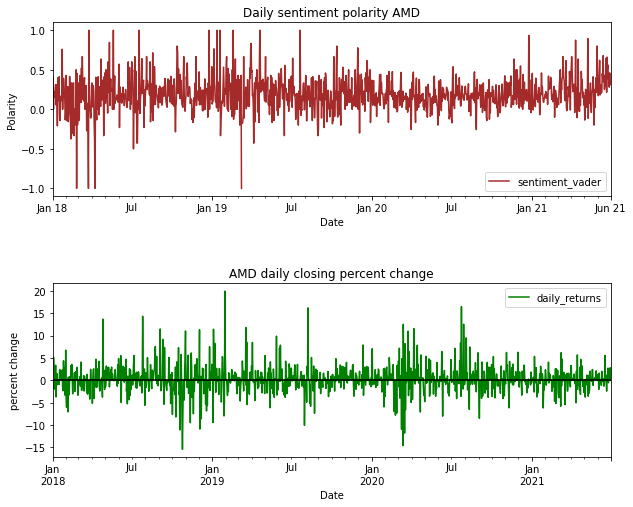

In [56]:
fig, (ax , ax1) = plt.subplots(2, 1, figsize=(10,8))
fig.subplots_adjust(hspace = 0.5)

merged_data.plot.line( y = 'daily_returns',color='green', ax = ax1, use_index=True)
merged_data.plot.line( y = 'sentiment_vader',color='brown', ax = ax)

    #black line in return = 0
plt.axhline(y=0.0, color='black')
    
ax.set( xlabel='Date', ylabel='Polarity', title='Daily sentiment polarity AMD' )
ax1.set( xlabel='Date', ylabel='percent change', title='AMD adjusted close price')
#ax1.yaxis.set_major_formatter('${x:,.0f}')
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

#ax1.set_xticklabels([x.strftime("%b %y") for x in merged_data.index], rotation=45)
    #    ax.set_title('Monthly Balance')
ax1.set_title('AMD daily closing percent change')
#ax1.set_ylim(-1,1)

In [21]:
df_TSLA = pandas_df[pandas_df['company'].str.contains('TSLA', na=False)]
daily_vader_polarity_posts_TSLA = df_TSLA.groupby(pd.Grouper(key='created_utc',freq='D'))['vader_category'].value_counts().unstack(fill_value=0)


#make formula according to RANCO
daily_vader_polarity_posts_TSLA['sentiment_vader'] = (daily_vader_polarity_posts_TSLA['positive']-daily_vader_polarity_posts_TSLA['negative'])/(daily_vader_polarity_posts_TSLA['positive']+daily_vader_polarity_posts_TSLA['negative'])

tsla_df = yf.download('TSLA', start='2018-01-01', end='2021-06-30', progress=False,)
daily_vader_polarity_posts_TSLA.index.names= ['Date']
merged_data = pd.merge(daily_vader_polarity_posts_TSLA, tsla_df, how = 'outer', on = 'Date')
merged_data['daily_returns'] = merged_data['Adj Close'].pct_change(1)*100
merged_data['total_msgs'] = merged_data['positive']+merged_data['negative']+merged_data['positive']

(-20.0, 20.0)

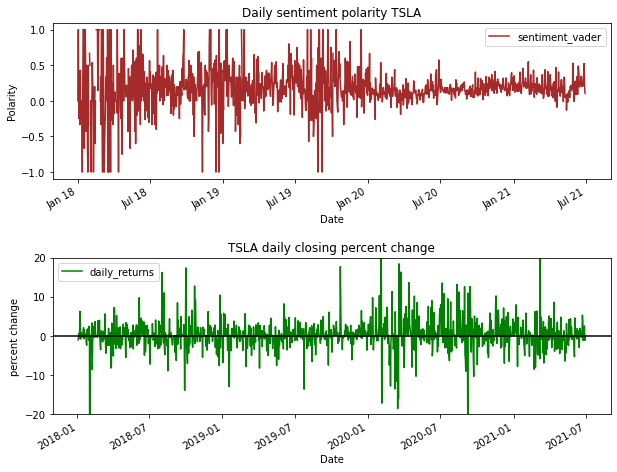

In [22]:
fig, (ax , ax1) = plt.subplots(2, 1, figsize=(10,8))
fig.subplots_adjust(hspace = 0.5)

merged_data.plot.line( y = 'daily_returns',color='green', ax = ax1, use_index=True)
merged_data.plot.line( y = 'sentiment_vader',color='brown', ax = ax)

    #black line in return = 0
plt.axhline(y=0.0, color='black')
    
ax.set( xlabel='Date', ylabel='Polarity', title='Daily sentiment polarity TSLA' )
ax1.set( xlabel='Date', ylabel='percent change', title='TSLA adjusted close price')
#ax1.yaxis.set_major_formatter('${x:,.0f}')
#ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

#ax1.set_xticklabels([x.strftime("%b %y") for x in merged_data.index], rotation=45)
    #    ax.set_title('Monthly Balance')
ax1.set_title('TSLA daily closing percent change')
ax1.set_ylim(-20,20)

In [23]:
merged_data.sort_values('Date')

,negative,neutral,positive,sentiment_vader,Open,High,Low,Close,Adj Close,Volume,daily_returns,total_msgs
Date,,,,,,,,,,,,
2018-01-01,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2018-01-02,1.0,1.0,1.0,0.000000,62.400002,64.421997,62.200001,64.106003,64.106003,21761000.0,NaN,3.0
2018-01-03,0.0,1.0,5.0,1.000000,64.199997,65.050003,63.110001,63.450001,63.450001,22607500.0,-1.023308,10.0
2018-01-04,4.0,1.0,3.0,-0.142857,62.574001,63.709999,61.136002,62.924000,62.924000,49731500.0,-0.829001,10.0
2018-01-05,5.0,6.0,3.0,-0.250000,63.324001,63.448002,62.400002,63.316002,63.316002,22956000.0,0.622977,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,13.0,32.0,27.0,0.350000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,67.0
2021-06-27,15.0,40.0,48.0,0.523810,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,111.0
2021-06-28,52.0,175.0,94.0,0.287671,671.640015,694.700012,670.320007,688.719971,688.719971,21628200.0,2.507922,240.0


In [24]:
#load google trends for TSLA
TSLA_trend = pd.read_csv("TSLA_trend.csv")
# convert ojbect to datetime 
TSLA_trend['Week'] = pd.to_datetime(TSLA_trend['Week'])

TSLA_trend.rename(columns = {'Week':'Date'}, inplace = True)

TSLA_trend.set_index('Date', inplace=True)

TSLA_trend.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2018-01-07 to 2021-06-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   TSLA    182 non-null    int64
dtypes: int64(1)
memory usage: 2.8 KB


In [25]:
TSLA_trend

,TSLA
Date,
2018-01-07,6
2018-01-14,5
2018-01-21,6
2018-01-28,5
2018-02-04,11
...,...
2021-05-30,19
2021-06-06,20
2021-06-13,18


In [26]:
merged_data = pd.merge(merged_data, TSLA_trend, how = 'outer', on = 'Date')
merged_data

,negative,neutral,positive,sentiment_vader,Open,High,Low,Close,Adj Close,Volume,daily_returns,total_msgs,TSLA
Date,,,,,,,,,,,,,
2018-01-01,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2018-01-02,1.0,1.0,1.0,0.000000,62.400002,64.421997,62.200001,64.106003,64.106003,21761000.0,NaN,3.0,NaN
2018-01-03,0.0,1.0,5.0,1.000000,64.199997,65.050003,63.110001,63.450001,63.450001,22607500.0,-1.023308,10.0,NaN
2018-01-04,4.0,1.0,3.0,-0.142857,62.574001,63.709999,61.136002,62.924000,62.924000,49731500.0,-0.829001,10.0,NaN
2018-01-05,5.0,6.0,3.0,-0.250000,63.324001,63.448002,62.400002,63.316002,63.316002,22956000.0,0.622977,11.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-02,NaN,NaN,NaN,NaN,69.688004,70.389999,68.101997,68.750000,68.750000,18524000.0,-89.900993,NaN,NaN
2018-02-26,NaN,NaN,NaN,NaN,70.699997,71.800003,70.472000,71.484001,71.484001,21700000.0,3.976729,NaN,NaN
2018-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [27]:
merged_data.sort_values('Date')

,negative,neutral,positive,sentiment_vader,Open,High,Low,Close,Adj Close,Volume,daily_returns,total_msgs,TSLA
Date,,,,,,,,,,,,,
2018-01-01,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2018-01-02,1.0,1.0,1.0,0.000000,62.400002,64.421997,62.200001,64.106003,64.106003,21761000.0,NaN,3.0,NaN
2018-01-03,0.0,1.0,5.0,1.000000,64.199997,65.050003,63.110001,63.450001,63.450001,22607500.0,-1.023308,10.0,NaN
2018-01-04,4.0,1.0,3.0,-0.142857,62.574001,63.709999,61.136002,62.924000,62.924000,49731500.0,-0.829001,10.0,NaN
2018-01-05,5.0,6.0,3.0,-0.250000,63.324001,63.448002,62.400002,63.316002,63.316002,22956000.0,0.622977,11.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,13.0,32.0,27.0,0.350000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,67.0,NaN
2021-06-27,15.0,40.0,48.0,0.523810,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,111.0,19.0
2021-06-28,52.0,175.0,94.0,0.287671,671.640015,694.700012,670.320007,688.719971,688.719971,21628200.0,2.507922,240.0,NaN


In [28]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1275 entries, 2018-01-01 to 2018-04-08
Data columns (total 13 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   negative         1270 non-null   float64
 1   neutral          1270 non-null   float64
 2   positive         1270 non-null   float64
 3   sentiment_vader  1263 non-null   float64
 4   Open             879 non-null    float64
 5   High             879 non-null    float64
 6   Low              879 non-null    float64
 7   Close            879 non-null    float64
 8   Adj Close        879 non-null    float64
 9   Volume           879 non-null    float64
 10  daily_returns    1270 non-null   float64
 11  total_msgs       1270 non-null   float64
 12  TSLA             182 non-null    float64
dtypes: float64(13)
memory usage: 139.5 KB


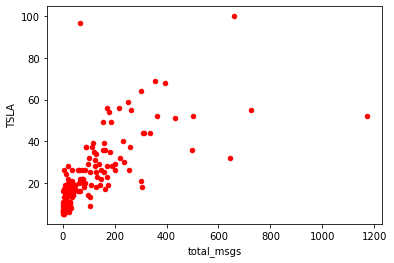

In [29]:
merged_data.plot(kind='scatter',x = 'total_msgs', y='TSLA',color='red')
plt.show()

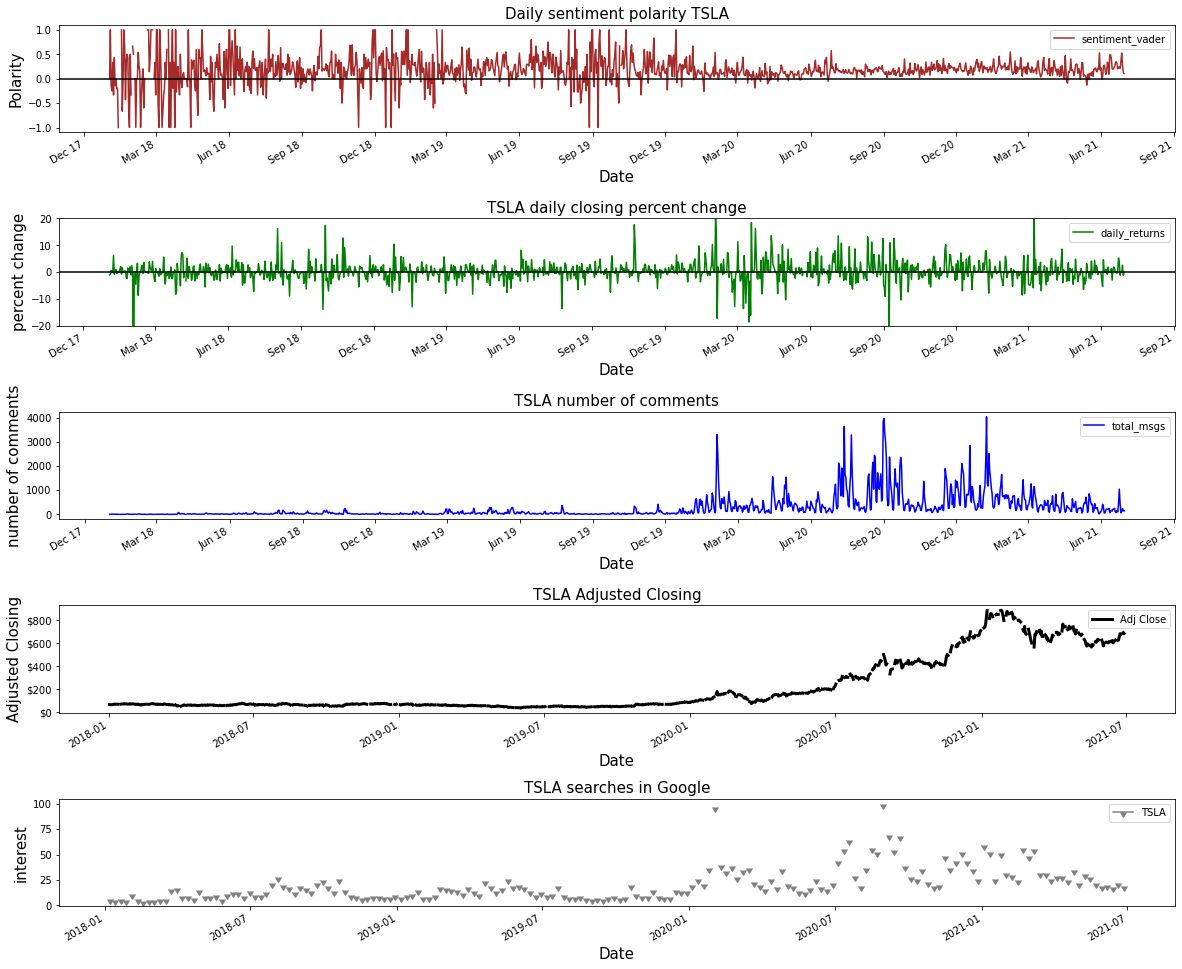

In [30]:
fig, (ax , ax1, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(20,18))
fig.subplots_adjust(hspace = 0.8)

merged_data.plot.line( y = 'daily_returns',color='green', ax = ax1, use_index=True)
merged_data.plot.line( y = 'sentiment_vader',color='brown', ax = ax)
merged_data.plot.line( y = 'total_msgs',color='blue', ax = ax2)
merged_data.plot.line( y = 'Adj Close',color='black', ax = ax3, linewidth=3)
merged_data.plot.line( y = 'TSLA',color='gray', ax = ax4, marker=11 )

#black line in return = 0
#plt.axhline(y=0.0, color='black')
ax.axhline(y=0, color="black")
ax1.axhline(y=0, color="black")

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.xaxis.label.set_size(15)
ax2.yaxis.label.set_size(15)

ax3.xaxis.label.set_size(15)
ax3.yaxis.label.set_size(15)

ax4.xaxis.label.set_size(15)
ax4.yaxis.label.set_size(15)

ax.set( xlabel='Date', ylabel='Polarity', title='Daily sentiment polarity TSLA' )
ax1.set( xlabel='Date', ylabel='percent change', title='TSLA daily closing percent change')
ax2.set( xlabel='Date', ylabel='number of comments', title='TSLA number of comments')
ax3.set( xlabel='Date', ylabel='Adjusted Closing', title='TSLA Adjusted Closing')

ax4.set( xlabel='Date', ylabel='interest', title='TSLA searches in Google')

ax3.yaxis.set_major_formatter('${x:,.0f}')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

#ax1.set_xticklabels([x.strftime("%b %y") for x in merged_data.index], rotation=45)
    #    ax.set_title('Monthly Balance')
#ax.title.set_size(15)
#ax1.set_title('TSLA daily closing percent change')
ax1.set_ylim(-20,20)
ax.title.set_size(15)
ax1.title.set_size(15)
ax2.title.set_size(15)
ax3.title.set_size(15)
ax4.title.set_size(15)


In [31]:
merged_data

,negative,neutral,positive,sentiment_vader,Open,High,Low,Close,Adj Close,Volume,daily_returns,total_msgs,TSLA
Date,,,,,,,,,,,,,
2018-01-01,0.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN
2018-01-02,1.0,1.0,1.0,0.000000,62.400002,64.421997,62.200001,64.106003,64.106003,21761000.0,NaN,3.0,NaN
2018-01-03,0.0,1.0,5.0,1.000000,64.199997,65.050003,63.110001,63.450001,63.450001,22607500.0,-1.023308,10.0,NaN
2018-01-04,4.0,1.0,3.0,-0.142857,62.574001,63.709999,61.136002,62.924000,62.924000,49731500.0,-0.829001,10.0,NaN
2018-01-05,5.0,6.0,3.0,-0.250000,63.324001,63.448002,62.400002,63.316002,63.316002,22956000.0,0.622977,11.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-02,NaN,NaN,NaN,NaN,69.688004,70.389999,68.101997,68.750000,68.750000,18524000.0,-89.900993,NaN,NaN
2018-02-26,NaN,NaN,NaN,NaN,70.699997,71.800003,70.472000,71.484001,71.484001,21700000.0,3.976729,NaN,NaN
2018-01-14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0


In [158]:
merged_data.to_csv('TSLA_merged_data.csv')

In [136]:
#%pip install statsmodels

Note: you may need to restart the kernel to use updated packages.


In [58]:

test_data = merged_data.loc[merged_data.index >= '2020-01-01']

test_data

,negative,neutral,positive,sentiment_vader,Open,High,Low,Close,Adj Close,Volume,daily_returns,total_msgs,TSLA
Date,,,,,,,,,,,,,
2020-01-01,5.0,10.0,14.0,0.473684,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,33.0,NaN
2020-01-02,31.0,39.0,43.0,0.162162,84.900002,86.139999,84.342003,86.052002,86.052002,47660500.0,2.851817,117.0,NaN
2020-01-03,48.0,58.0,64.0,0.142857,88.099998,90.800003,87.384003,88.601997,88.601997,88892500.0,2.963319,176.0,NaN
2020-01-04,14.0,11.0,24.0,0.263158,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,62.0,NaN
2020-01-05,2.0,10.0,10.0,0.666667,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,22.0,20.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,13.0,32.0,27.0,0.350000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,67.0,NaN
2021-06-27,15.0,40.0,48.0,0.523810,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,111.0,19.0
2021-06-28,52.0,175.0,94.0,0.287671,671.640015,694.700012,670.320007,688.719971,688.719971,21628200.0,2.507922,240.0,NaN


In [57]:
# statistical tests
# the daily returns is stationary. p values
import scipy.stats as stats
from statsmodels.tsa.stattools import adfuller

test_data = test_data['daily_returns'].dropna()


adfuller(test_data)


(-23.26246158913143,
 0.0,
 0,
 546,
 {'1%': -3.442383534871275,
  '5%': -2.8668480382580386,
  '10%': -2.569597004924258},
 3038.454949414786)

stop here

In [59]:
# statistical tests
# the daily returns is stationary. p values
test_data = test_data['sentiment_vader'].dropna()


adfuller(test_data)


(-2.98779584842221,
 0.03604993971809818,
 14,
 532,
 {'1%': -3.442701754304053,
  '5%': -2.866988120523906,
  '10%': -2.5696716542766693},
 -971.2658762821691)

In [55]:
from statsmodels.tsa.stattools import grangercausalitytests
test_data = merged_data.loc[merged_data.index >= '2020-01-01']
test_data= test_data.dropna(subset=['sentiment_vader', 'daily_returns'])
test_data

grangercausalitytests(test_data[['daily_returns', 'sentiment_vader']], maxlag=[5], verbose = True)


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=2.4225  , p=0.0347  , df_denom=531, df_num=5
ssr based chi2 test:   chi2=12.3632 , p=0.0301  , df=5
likelihood ratio test: chi2=12.2243 , p=0.0318  , df=5
parameter F test:         F=2.4225  , p=0.0347  , df_denom=531, df_num=5


{5: ({'ssr_ftest': (2.4224644522490264, 0.03465135803643054, 531.0, 5),
   'ssr_chi2test': (12.363236658370738, 0.03013571270138553, 5),
   'lrtest': (12.224339703097485, 0.03183980986498662, 5),
   'params_ftest': (2.422464452249107, 0.03465135803642551, 531.0, 5.0)},
   array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}

In [60]:
test_data

Date
2020-01-01    0.473684
2020-01-02    0.162162
2020-01-03    0.142857
2020-01-04    0.263158
2020-01-05    0.666667
                ...   
2021-06-26    0.350000
2021-06-27    0.523810
2021-06-28    0.287671
2021-06-29    0.130435
2021-06-30    0.104167
Name: sentiment_vader, Length: 547, dtype: float64

In [61]:
df_AAPL = pandas_df[pandas_df['company'].str.contains('AAPL', na=False)]
daily_vader_polarity_posts_AAPL = df_AAPL.groupby(pd.Grouper(key='created_utc',freq='D'))['vader_category'].value_counts().unstack(fill_value=0)


#make formula according to RANCO
daily_vader_polarity_posts_AAPL['sentiment_vader'] = (daily_vader_polarity_posts_AAPL['positive']-daily_vader_polarity_posts_AAPL['negative'])/(daily_vader_polarity_posts_AAPL['positive']+daily_vader_polarity_posts_AAPL['negative'])

aapl_df = yf.download('AAPL', start='2018-01-01', end='2021-06-30', progress=False,)
daily_vader_polarity_posts_AAPL.index.names= ['Date']
merged_data = pd.merge(daily_vader_polarity_posts_AAPL, aapl_df, how = 'outer', on = 'Date')
merged_data['daily_returns'] = merged_data['Adj Close'].pct_change(1)*100
merged_data['total_msgs'] = merged_data['positive']+merged_data['negative']+merged_data['positive']

In [62]:
#load google trends for AAPL
AAPL_trend = pd.read_csv("AAPL_trend.csv")
# convert ojbect to datetime 
AAPL_trend['Week'] = pd.to_datetime(AAPL_trend['Week'])

AAPL_trend.rename(columns = {'Week':'Date'}, inplace = True)

AAPL_trend.set_index('Date', inplace=True)

AAPL_trend.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 182 entries, 2018-01-07 to 2021-06-27
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   AAPL    182 non-null    int64
dtypes: int64(1)
memory usage: 2.8 KB


In [63]:
merged_data = pd.merge(merged_data, AAPL_trend, how = 'outer', on = 'Date')
merged_data

,negative,neutral,positive,sentiment_vader,Open,High,Low,Close,Adj Close,Volume,daily_returns,total_msgs,AAPL
Date,,,,,,,,,,,,,
2018-01-01,0.0,7.0,5.0,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,10.0,NaN
2018-01-02,1.0,2.0,4.0,0.600000,42.540001,43.075001,42.314999,43.064999,41.075394,102223600.0,NaN,9.0,NaN
2018-01-03,1.0,2.0,0.0,-1.000000,43.132500,43.637501,42.990002,43.057499,41.068249,118071600.0,-0.017395,1.0,NaN
2018-01-04,1.0,0.0,1.0,0.000000,43.134998,43.367500,43.020000,43.257500,41.259007,89738400.0,0.464490,3.0,NaN
2018-01-05,1.0,0.0,0.0,-1.000000,43.360001,43.842499,43.262501,43.750000,41.728764,94640000.0,1.138556,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-28,20.0,40.0,28.0,0.166667,133.410004,135.250000,133.350006,134.779999,134.014359,62111300.0,1.254608,76.0,NaN
2021-06-29,18.0,34.0,26.0,0.181818,134.800003,136.490005,134.350006,136.330002,135.555527,64556100.0,1.150002,70.0,NaN
2021-06-30,21.0,39.0,21.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,63.0,NaN


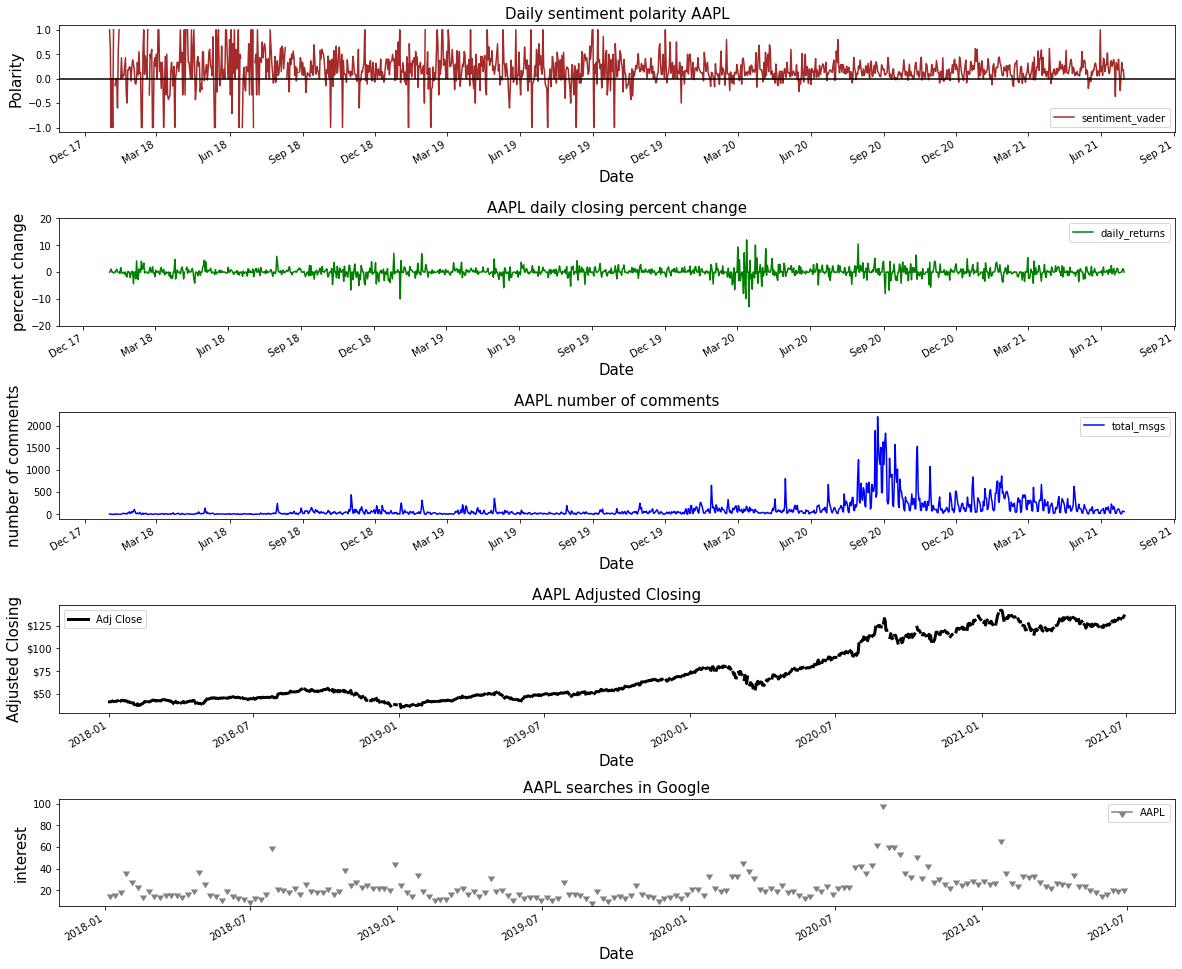

In [64]:
fig, (ax , ax1, ax2, ax3, ax4) = plt.subplots(5, 1, figsize=(20,18))
fig.subplots_adjust(hspace = 0.8)

merged_data.plot.line( y = 'daily_returns',color='green', ax = ax1, use_index=True)
merged_data.plot.line( y = 'sentiment_vader',color='brown', ax = ax)
merged_data.plot.line( y = 'total_msgs',color='blue', ax = ax2)
merged_data.plot.line( y = 'Adj Close',color='black', ax = ax3, linewidth=3)
merged_data.plot.line( y = 'AAPL',color='gray', ax = ax4, marker=11 )

#black line in return = 0

ax.axhline(y=0, color="black")

ax.xaxis.label.set_size(15)
ax.yaxis.label.set_size(15)

ax1.xaxis.label.set_size(15)
ax1.yaxis.label.set_size(15)

ax2.xaxis.label.set_size(15)
ax2.yaxis.label.set_size(15)

ax3.xaxis.label.set_size(15)
ax3.yaxis.label.set_size(15)

ax4.xaxis.label.set_size(15)
ax4.yaxis.label.set_size(15)

ax.set( xlabel='Date', ylabel='Polarity', title='Daily sentiment polarity AAPL' )
ax1.set( xlabel='Date', ylabel='percent change', title='AAPL daily closing percent change')
ax2.set( xlabel='Date', ylabel='number of comments', title='AAPL number of comments')
ax3.set( xlabel='Date', ylabel='Adjusted Closing', title='AAPL Adjusted Closing')

ax4.set( xlabel='Date', ylabel='interest', title='AAPL searches in Google')

ax3.yaxis.set_major_formatter('${x:,.0f}')

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax1.xaxis.set_major_locator(mdates.MonthLocator(interval=3))
ax2.xaxis.set_major_locator(mdates.MonthLocator(interval=3))

ax.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))
ax2.xaxis.set_major_formatter(mdates.DateFormatter("%b %y"))

#ax1.set_xticklabels([x.strftime("%b %y") for x in merged_data.index], rotation=45)
    #    ax.set_title('Monthly Balance')
#ax.title.set_size(15)
#ax1.set_title('TSLA daily closing percent change')
ax1.set_ylim(-20,20)
ax.title.set_size(15)
ax1.title.set_size(15)
ax2.title.set_size(15)
ax3.title.set_size(15)
ax4.title.set_size(15)

In [164]:
merged_data.to_csv('AAPLmerged_data.csv')

In [1]:
merged_data

NameError: name 'merged_data' is not defined

In [69]:

test_data = merged_data.loc[merged_data.index >= '2020-01-01']

test_data

,negative,neutral,positive,sentiment_vader,Open,High,Low,Close,Adj Close,Volume,daily_returns,total_msgs,AAPL
Date,,,,,,,,,,,,,
2020-01-01,3.0,9.0,9.0,0.500000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,21.0,NaN
2020-01-02,40.0,75.0,80.0,0.333333,74.059998,75.150002,73.797501,75.087502,73.785919,135480400.0,2.281650,200.0,NaN
2020-01-03,66.0,72.0,66.0,0.000000,74.287498,75.144997,74.125000,74.357498,73.068565,146322800.0,-0.972210,198.0,NaN
2020-01-04,11.0,18.0,15.0,0.153846,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,41.0,NaN
2020-01-05,4.0,5.0,8.0,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,20.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-06-26,3.0,5.0,3.0,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,9.0,NaN
2021-06-27,4.0,14.0,8.0,0.333333,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,20.0,22.0
2021-06-28,20.0,40.0,28.0,0.166667,133.410004,135.250000,133.350006,134.779999,134.014359,62111300.0,1.254608,76.0,NaN


In [66]:
# statistical tests
# the daily returns is stationary. p values


test_data = test_data['daily_returns'].dropna()


adfuller(test_data)

(-5.090953698392241,
 1.4618213593059356e-05,
 19,
 527,
 {'1%': -3.442819521824351,
  '5%': -2.8670399588708047,
  '10%': -2.5696992792614384},
 2301.1236717005495)

In [68]:
# statistical tests
# the daily returns is stationary. p values
test_data = test_data['sentiment_vader'].dropna()


adfuller(test_data)

(-5.71400690487564,
 7.19056189071003e-07,
 15,
 531,
 {'1%': -3.4427251295084678,
  '5%': -2.8669984098683736,
  '10%': -2.5696771375119254},
 -423.44254039481393)

In [81]:
test_data = merged_data.loc[merged_data.index >= '2020-01-01']
test_data= test_data.dropna(subset=['sentiment_vader', 'daily_returns'])
test_data

grangercausalitytests(test_data[['daily_returns', 'sentiment_vader']], maxlag=[5], verbose = True)


Granger Causality
number of lags (no zero) 5
ssr based F test:         F=1.1100  , p=0.3539  , df_denom=531, df_num=5
ssr based chi2 test:   chi2=5.6651  , p=0.3402  , df=5
likelihood ratio test: chi2=5.6357  , p=0.3433  , df=5
parameter F test:         F=1.1100  , p=0.3539  , df_denom=531, df_num=5


{5: ({'ssr_ftest': (1.1100229693932329, 0.35391920619719025, 531.0, 5),
   'ssr_chi2test': (5.665088977505953, 0.3401825793036968, 5),
   'lrtest': (5.635687370619507, 0.34329652638094393, 5),
   'params_ftest': (1.1100229693932107, 0.35391920619720973, 531.0, 5.0)},
   array([[0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
          [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]])])}